## Лабораторная работа №1

#### Импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from scipy import stats

from plots_draw import draw_qualitative, draw_quantitative
from stats_methods import quartile_method, sigma_method

from functools import reduce

In [2]:
qualitatives = ['cat9_age', 'cat12_paymentMethod']
quantitatives = ['num1_19', 'num2_19', 'num3_19']

In [3]:
df = pd.read_excel('first_practice_dataframe.xlsx', usecols=(qualitatives + quantitatives))

df

,cat9_age,cat12_paymentMethod,num1_19,num2_19,num3_19
0,below 21 years,cash,248.417287,-263.934644,663.188133
1,59 years and above,credit,-9999.000000,3762.308926,409.817217
2,59 years and above,Credit,118.937438,-404.406382,540.369226
3,59 years and above,Cash,424.097198,1405.586130,382.262612
4,59 years and above,credit,256.039150,1540.601147,410.063319
...,...,...,...,...,...
995,below 21 years,Credit,410.100505,700.453581,371.324421
996,59 years and above,Credit,117.768606,389.180003,558.240418
997,21 to 35 years,,412.964922,-108.592286,780.568191
998,59 years and above,Cash,174.329086,115.216845,474.998885


#### Проверим типы нашего датасета

In [4]:
df.dtypes

cat9_age                object
cat12_paymentMethod     object
num1_19                float64
num2_19                float64
num3_19                 object
dtype: object

#### Выводим графики всех наших данных

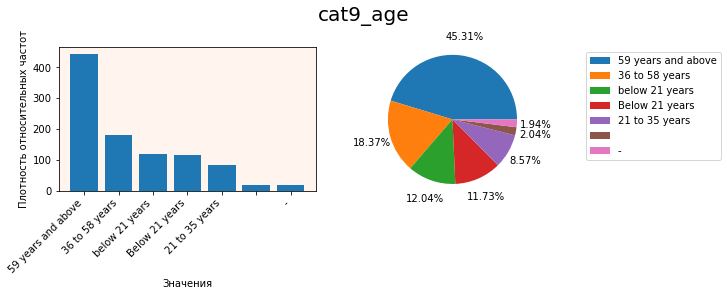

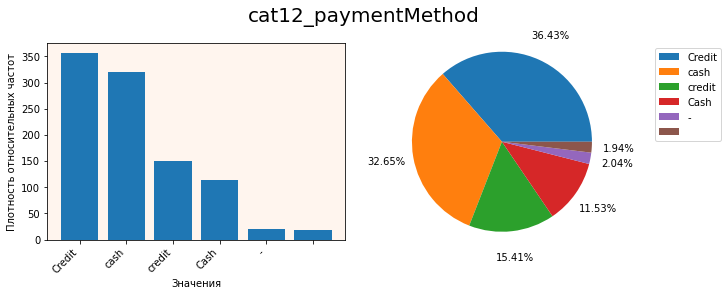

In [5]:
for name in qualitatives:
    draw_qualitative(df[name], name, 'Значения', 'Плотность относительных частот')

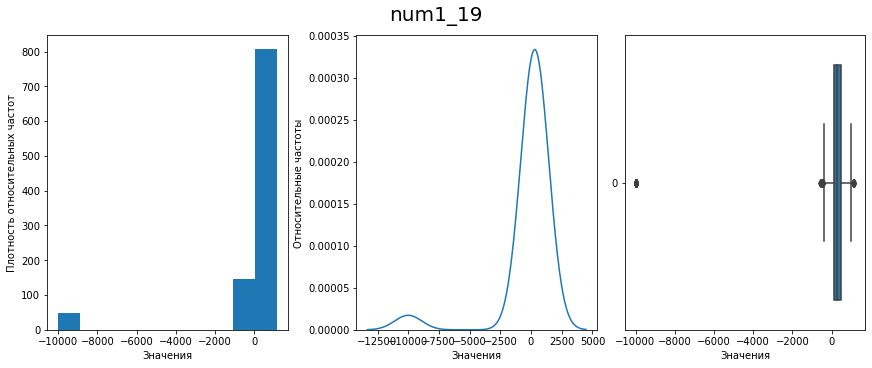

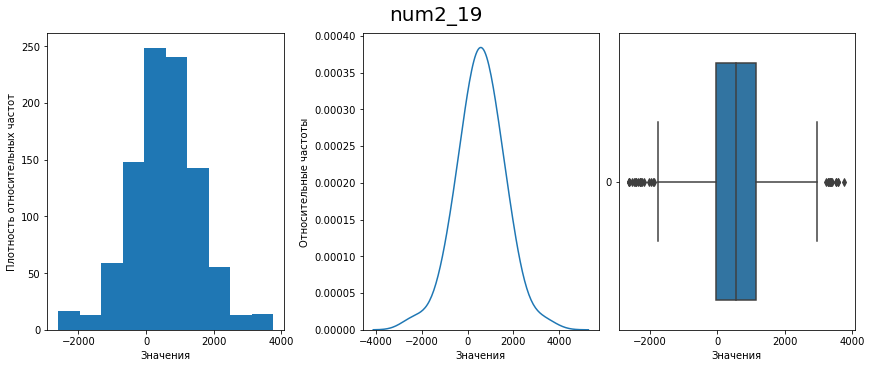

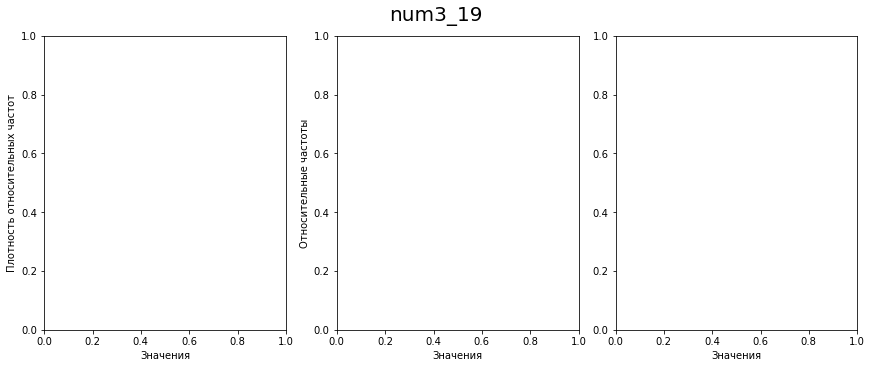

In [6]:
for name in quantitatives:
    try:
        draw_quantitative(df[name], name, 'Значения')
    except:
        pass

#### Последний столбец не является object, поэтому для начала приведём все значения к правильному типу

In [7]:
for name in qualitatives:
    df[name] = df[name].replace({'-': None, ' ':None, np.nan: None})
    df[name] = df[name].apply(lambda x: x.capitalize() if isinstance(x, str) else x)

for name in quantitatives:
    df[name] = pd.to_numeric(df[name], errors='coerce')

In [8]:
df.dtypes

cat9_age                object
cat12_paymentMethod     object
num1_19                float64
num2_19                float64
num3_19                float64
dtype: object

#### Ещё раз выведем графики для наглядности

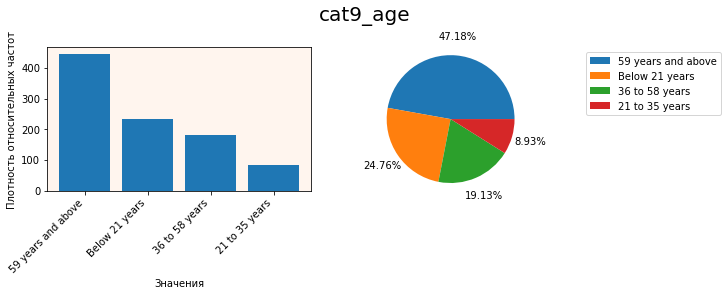

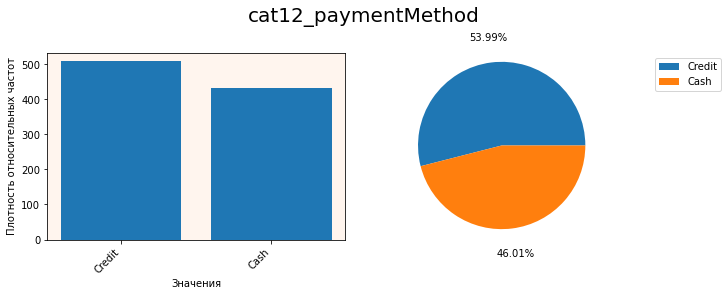

In [9]:
for name in qualitatives:
    draw_qualitative(df[name], name, 'Значения', 'Плотность относительных частот')

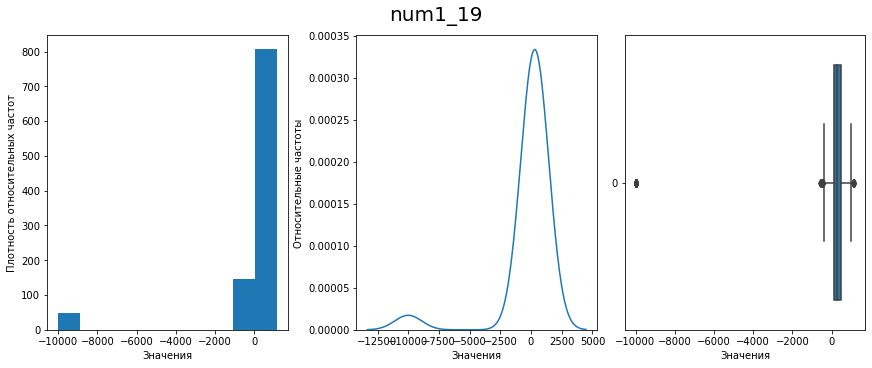

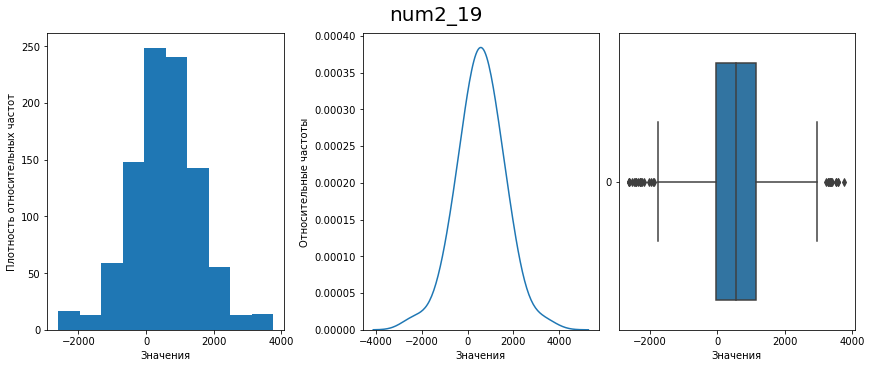

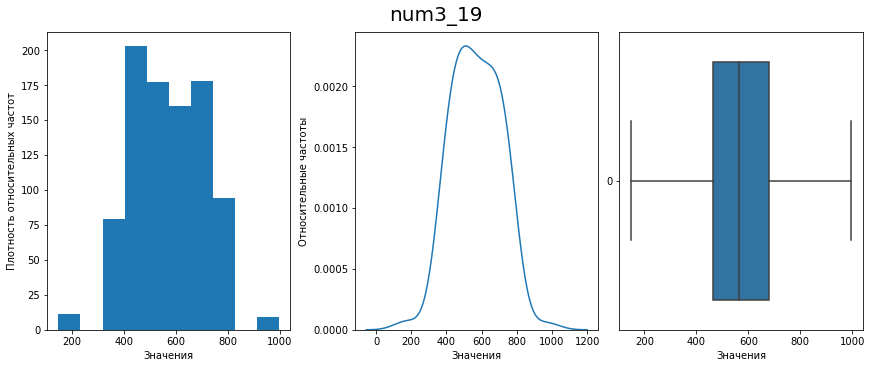

In [10]:
for name in quantitatives:
    try:
        draw_quantitative(df[name], name, 'Значения')
    except:
        pass

#### Убираем выбросы c помощью метода квартилей сталкеры приготовьтесь

In [11]:
# Проверяем сколько сейчас у нас значений
for row in quantitatives:
    print(f'Not nan values in row {row}: {df[row].count()}')

Not nan values in row num1_19: 1000
Not nan values in row num2_19: 952
Not nan values in row num3_19: 911


In [12]:
df_quartile_copy = df.copy()


drop_list = [quartile_method(df_quartile_copy, name) for name in quantitatives]
drop_list_interval = reduce(lambda x, y: x | y, drop_list)

df_quartile_copy = df_quartile_copy.loc[~drop_list_interval]

df_quartile_copy = df_quartile_copy.reset_index()
pop_indexes = df_quartile_copy.pop('index')

In [13]:
print('Значение после удаления выбросов методом квартилей')
for row in quantitatives:
    print(f'Not nan values in row {row}: {df_quartile_copy[row].count()}')

Значение после удаления выбросов методом квартилей
Not nan values in row num1_19: 906
Not nan values in row num2_19: 861
Not nan values in row num3_19: 823


#### Проверим графически

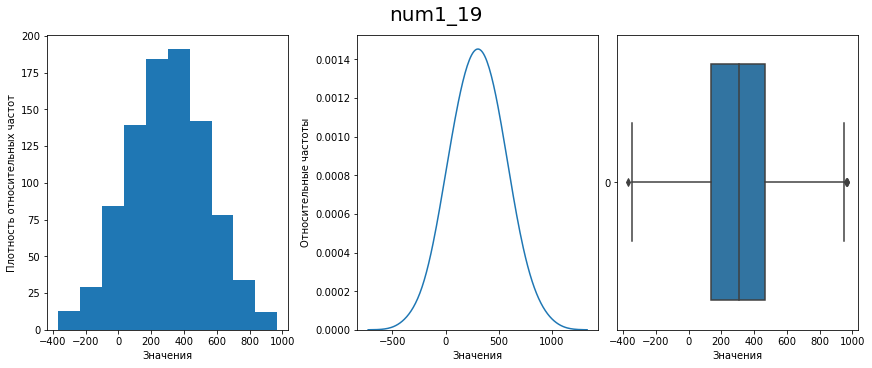

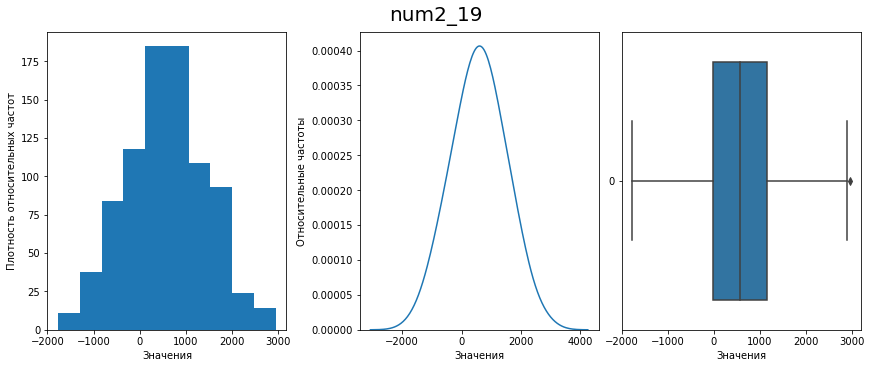

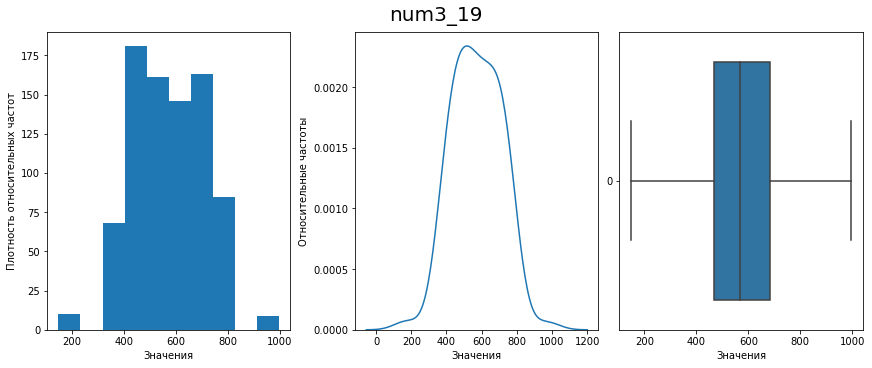

In [14]:
for name in quantitatives:
    try:
        draw_quantitative(df_quartile_copy[name], name, 'Значения')
    except:
        pass

#### Метод сигм

In [15]:
df_sigma_copy = df.copy()

df_sigma_copy = sigma_method(df_sigma_copy)

In [16]:
print('Значение после удаления выбросов методом сигм')
for row in quantitatives:
    print(f'Not nan values in row {row}: {df_sigma_copy[row].count()}')

Значение после удаления выбросов методом сигм
Not nan values in row num1_19: 894
Not nan values in row num2_19: 851
Not nan values in row num3_19: 811


#### Проверим графики

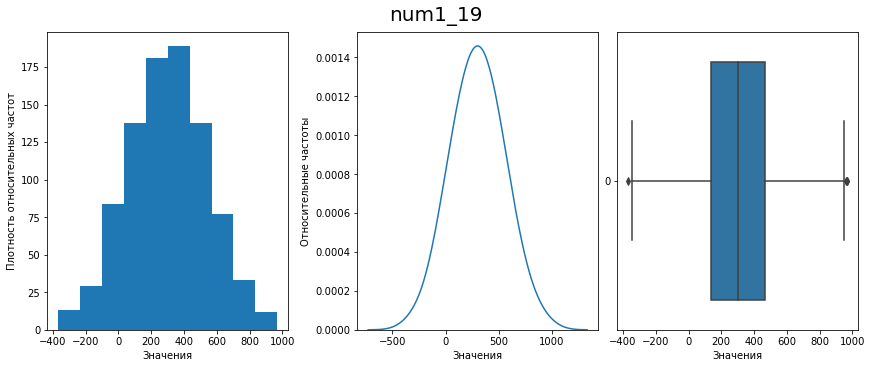

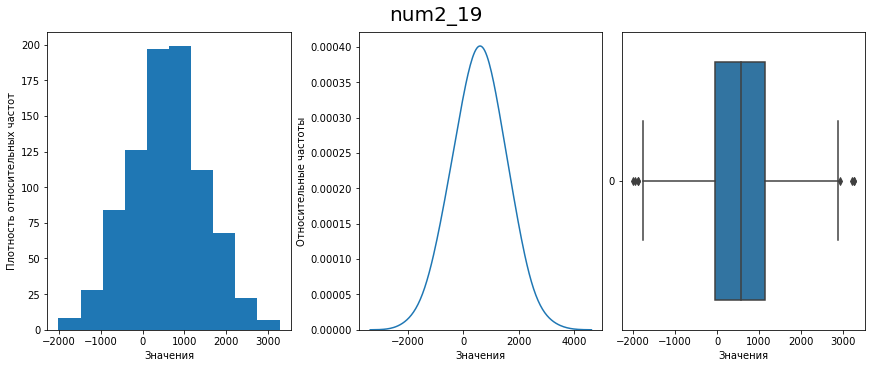

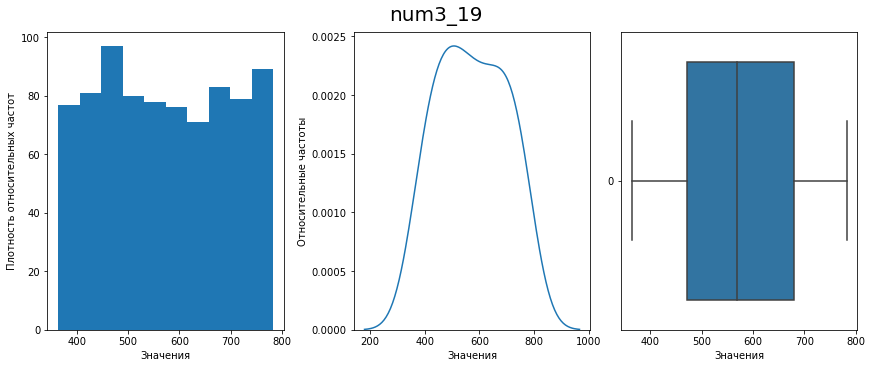

In [17]:
for name in quantitatives:
    try:
        draw_quantitative(df_sigma_copy[name], name, 'Значения')
    except:
        pass

### Используем в дальнейшем метод сигм

In [18]:
df = df_sigma_copy

#### Восстанавливаем пропущенные значения

In [19]:
# Смотрим сколько пропущенных значений в наших данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cat9_age             841 non-null    object 
 1   cat12_paymentMethod  839 non-null    object 
 2   num1_19              894 non-null    float64
 3   num2_19              851 non-null    float64
 4   num3_19              811 non-null    float64
dtypes: float64(3), object(2)
memory usage: 35.0+ KB


In [20]:
# Первый столбец метод k-ближайших значений

first_column = qualitatives[0]
df_filled = df.copy()

nan_index = df_filled[first_column][df_filled[first_column].isna() == True].index[0]

imputer = KNNImputer(n_neighbors=5)

le = LabelEncoder()
df_filled[first_column] = le.fit_transform(df[first_column])

nan_le_value = df_filled[first_column][nan_index]

df_filled[first_column] = df_filled[first_column].replace({nan_le_value: np.nan})

df_filled[first_column] = imputer.fit_transform(df_filled[[first_column]])

df_filled[first_column] = df_filled[first_column].apply(lambda x: round(x))

df_filled[first_column] = le.inverse_transform(df_filled[first_column])

df = df_filled

print(f'Есть ли nan элементы: {df[first_column].isna().any()}')

Есть ли nan элементы: False


Второй столбец заменяем самым популярным значением
Самое популярное значение

In [21]:
second_column = qualitatives[1]

most_frequence = df[second_column].value_counts().keys()[0]
df[second_column] = df[second_column].replace({np.nan: most_frequence})

print(f'Есть ли nan элементы: {df[second_column].isna().any()}')

Есть ли nan элементы: False


Третий столбец не содержит аномальных значений, так что переходим к четвертому
Вставим медианное значение

In [22]:
third_column = quantitatives[1]
df[third_column].fillna(df[third_column].median(), inplace=True)

print(f'Есть ли nan элементы: {df[third_column].isna().any()}')

Есть ли nan элементы: False


Для пятого столбца воспользуемся методом k-ближайших соседей 

In [23]:
four_column = quantitatives[2]

imputer = KNNImputer(n_neighbors=3)

# Заполняем пропущенные значения в выбранном столбце
df[[four_column]] = imputer.fit_transform(df[[four_column]])

print(f'Есть ли nan элементы: {df[four_column].isna().any()}')

Есть ли nan элементы: False


### Преобразуем данные

#### Нормализируем и стандартизируем

In [24]:
# Нормализация
df[[*map(lambda x: x + '_norm', quantitatives)]] = MinMaxScaler().fit_transform(df[[*quantitatives]])

# Стандартизация
df[[*map(lambda x: x + '_stand', quantitatives)]] = StandardScaler().fit_transform(df[[*quantitatives]])

df[[*map(lambda x: x + '_norm', quantitatives), *map(lambda x: x + '_stand', quantitatives)]].describe()

,num1_19_norm,num2_19_norm,num3_19_norm,num1_19_stand,num2_19_stand,num3_19_stand
count,894.000000,894.000000,894.000000,8.940000e+02,8.940000e+02,8.940000e+02
mean,0.500211,0.489802,0.499634,8.022417e-17,8.009998e-18,-5.503304e-16
std,0.180798,0.165898,0.278578,1.000560e+00,1.000560e+00,1.000560e+00
min,0.000000,0.000000,0.000000,-2.768239e+00,-2.954087e+00,-1.794522e+00
25%,0.377035,0.383558,0.275363,-6.816735e-01,-6.407805e-01,-8.055071e-01
50%,0.501047,0.488295,0.499634,4.627229e-03,-9.090093e-03,0.000000e+00
75%,0.622313,0.590215,0.735325,6.757325e-01,6.056099e-01,8.465256e-01
max,1.000000,1.000000,1.000000,2.765904e+00,3.077099e+00,1.797151e+00


#### One-Hot кодирование и Label кодирование

In [25]:
le = LabelEncoder()
df[qualitatives[1] + '_lb'] = le.fit_transform(df[qualitatives[1]])

enc = OneHotEncoder()
enc_df1 = pd.DataFrame(enc.fit_transform(df[[qualitatives[0]]]).toarray(), columns=enc.get_feature_names_out([qualitatives[0]]))
df = df.join(enc_df1)
df.head(10)

,cat9_age,cat12_paymentMethod,num1_19,num2_19,num3_19,num1_19_norm,num2_19_norm,num3_19_norm,num1_19_stand,num2_19_stand,num3_19_stand,cat12_paymentMethod_lb,cat9_age_21 to 35 years,cat9_age_36 to 58 years,cat9_age_59 years and above,cat9_age_Below 21 years
0,Below 21 years,Cash,248.417287,-263.934644,663.188133,0.460551,0.330442,0.715233,-0.219486,-0.961133,0.774362,0,0.0,0.0,0.0,1.0
1,59 years and above,Credit,118.937438,-404.406382,540.369226,0.363612,0.303824,0.421968,-0.755959,-1.121668,-0.278950,1,0.0,0.0,1.0,0.0
2,59 years and above,Cash,424.097198,1405.586130,382.262612,0.592078,0.646793,0.044444,0.508408,0.946843,-1.634896,0,0.0,0.0,1.0,0.0
3,59 years and above,Credit,256.039150,1540.601147,410.063319,0.466257,0.672377,0.110826,-0.187906,1.101142,-1.396473,1,0.0,0.0,1.0,0.0
4,59 years and above,Cash,448.417281,-218.375738,674.296682,0.610286,0.339074,0.741758,0.609174,-0.909067,0.869631,0,0.0,0.0,1.0,0.0
5,21 to 35 years,Cash,239.244764,569.123638,386.088410,0.453683,0.488295,0.053579,-0.257490,-0.009090,-1.602085,0,1.0,0.0,0.0,0.0
6,59 years and above,Credit,520.065265,255.559800,760.348052,0.663928,0.428879,0.947231,0.906032,-0.367440,1.607620,1,0.0,0.0,1.0,0.0
7,Below 21 years,Cash,364.574907,-223.740308,754.489012,0.547515,0.338058,0.933240,0.261790,-0.915197,1.557372,0,0.0,0.0,0.0,1.0
8,36 to 58 years,Cash,251.701233,563.828976,572.895542,0.463009,0.487292,0.499634,-0.205879,-0.015141,0.000000,0,0.0,1.0,0.0,0.0
9,59 years and above,Cash,78.256950,753.894266,781.541858,0.333155,0.523306,0.997837,-0.924510,0.202071,1.789381,0,0.0,0.0,1.0,0.0


#### Ещё раз выведем графики для проверки результатов

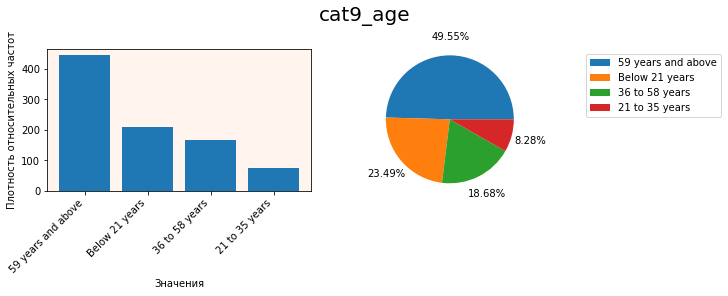

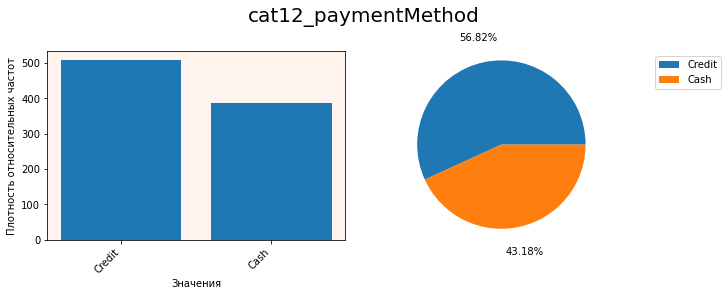

In [26]:
for name in qualitatives:
    draw_qualitative(df[name], name, 'Значения', 'Плотность относительных частот')

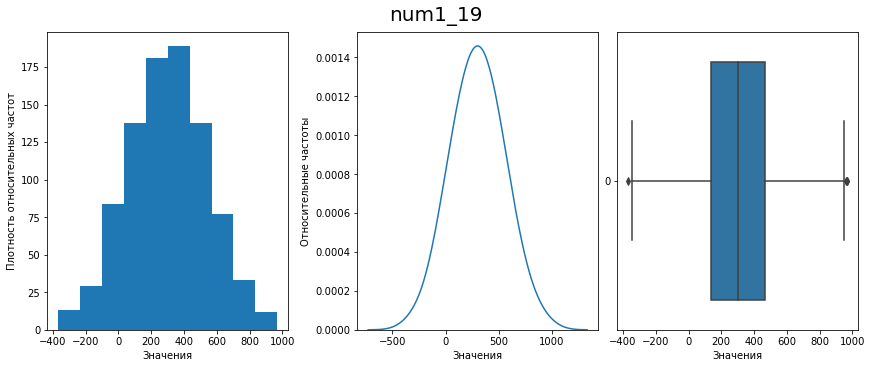

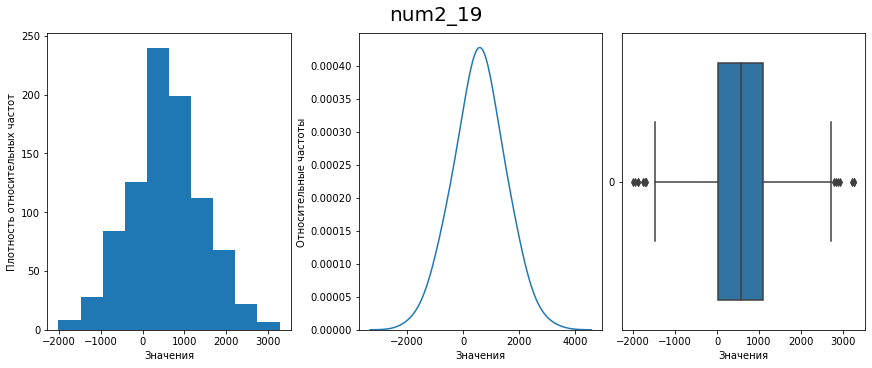

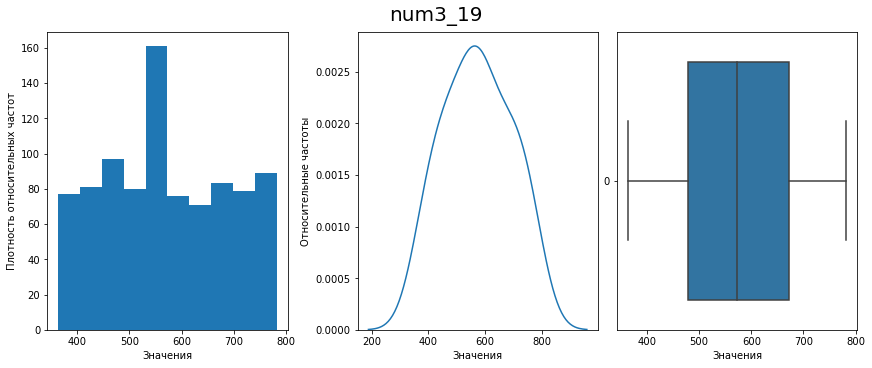

In [27]:
for name in quantitatives:
    try:
        draw_quantitative(df[name], name, 'Значения')
    except:
        pass